In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix,  classification_report, log_loss
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.preprocessing import PolynomialFeatures
# from sklearn.svm import SVC
# from sklearn.ensemble import RandomForestClassifier
from scipy.stats import norm
import scipy.io

import os
from os.path import join
import contextlib
from copy import deepcopy
import imp 
import time 
import sys

In [2]:
# load local functions
import stim_io

/home/jorvhar/miniconda3/envs/predlis/lib/python3.8/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '


## load raw data

In [3]:
pp = '2'
input_dir = '/media/jorvhar/Data1/MRIData/timing data/data/'

tr = 1.8
volumes = 245
nr_runs=12

In [4]:
puls_df = stim_io.pulses_load(pp, input_dir, 12)
volumes_df = stim_io.volumes_load(puls_df, tr, volumes, nr_runs=12)

mat, stimuli = stim_io.data_load(pp, join(input_dir, pp))
stim_df = stim_io.stims_load(puls_df, volumes_df, mat, stimuli)

# frequency range and bound settings

In [5]:
# settings
mat = scipy.io.loadmat(join(input_dir,'{}/{}_settings_tonotopy.mat'.format(pp, pp)))
all_freqs = mat['cfg']['freq_array'][0][0][0,:]

# must match the tonotopy settings
tunsteps       = 10
freqstep       = 1
fwhm           = np.linspace(25,(100), tunsteps)[::-1]
subsample      = np.arange(0,len(all_freqs), freqstep)
mustep         = np.diff(all_freqs[subsample])
sigmagrid      = np.log(2) / (mustep[0]* fwhm/2) **2
octgrid        = np.log2(np.exp(1) * fwhm * mustep[0])
muarray_bins   = all_freqs
muarray        = all_freqs[subsample]

# set range of tunings and sharpnesses
pref_range  = muarray                # match t
sharp_range = octgrid

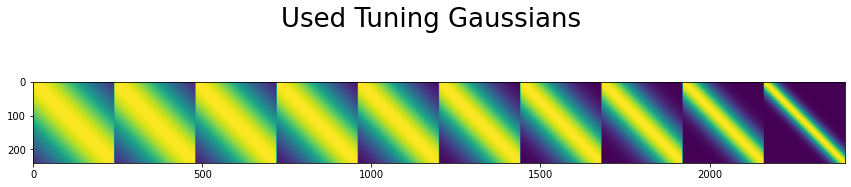

In [6]:
ax, fig = stim_io.freqs_plot(pref_range, sharp_range)

# hgf

## fit later

In [7]:
import Prediction.HGF as HGF

# import fit and sim models from the hgf
from Prediction.HGF import hgf_fit
from Prediction.HGF import hgf_sim

# import the presentation functions for plotting and storing
from Prediction.HGF import hgf_pres

# load our configuration functions
from Prediction.HGF.hgf_config import *
from Prediction.HGF.hgf import *

In [7]:
# create dict with our settings
c = {}
c['c_prc'] = {}

# set our number of levels
c['c_prc']['n_levels']   = 3

# define the priors for all levels
c['c_prc']['mu_0mu'] = np.array([99991, 1, 1])
c['c_prc']['mu_0sa'] = np.array([99992, 0, 0])
c['c_prc']['logsa_0mu'] = np.array([99993, np.log(0.1), np.log(0.1)])
c['c_prc']['logsa_0sa'] = np.array([1, 1, 1])

c['c_prc']['rhomu'] = np.array([0, 0, 0])
c['c_prc']['rhosa'] = np.array([0, 0, 0])
c['c_prc']['logkamu'] = np.array([np.log(1), np.log(1)])
c['c_prc']['logkasa'] = np.array([0, 0])

c['c_prc']['ommu'] = np.array([99993, -4, -8])
c['c_prc']['omsa'] = np.array([4**2, 4**2, 4**2])
c['c_prc']['logpiumu'] = np.array([-99993])
c['c_prc']['logpiusa'] = np.array([2**2])

# gather prior settings in vectors
c['c_prc']['priormus'] = np.concatenate([c['c_prc']['mu_0mu'], 
                                        c['c_prc']['logsa_0mu'], 
                                        c['c_prc']['rhomu'], 
                                        c['c_prc']['logkamu'], 
                                        c['c_prc']['ommu'], 
                                        c['c_prc']['logpiumu']], axis=0)
c['c_prc']['priorsas'] = np.concatenate([c['c_prc']['mu_0sa'], 
                                        c['c_prc']['logsa_0sa'], 
                                        c['c_prc']['rhosa'], 
                                        c['c_prc']['logkasa'], 
                                        c['c_prc']['omsa'], 
                                        c['c_prc']['logpiusa']], axis=0)

In [8]:
range_model = gaussian_obs_range_config
range_model = bayes_optimal_range_config

In [9]:
surp_dict = {}
prob_dict = {}
surp_dict_flat = {}
prob_dict_flat = {}

for blk in stim_df['block'].unique():
    
    # do HGFing
    stims = stim_df['frequencies_oct'][stim_df['block'] == blk].to_numpy()

    sim = hgf_sim.simModel(stims, hgf, 
                           np.array([10, 0.1, 1.0, 0.001, -0.001,
                                     -0.1, 0, 0, 0,
                                     0.08, 0.12, 0.12,
                                     3.6, 0.5, 2.5]) ,
                           obs_model=gaussian_obs,
                           obs_pvec=0.00002)

    r = hgf_fit.fitModel(sim['y'],
                         stims,
                         ehgf_config,
                         bayes_optimal_config, 
                         quasinewton_optim_config,
                         obs_range_model=range_model,
                         obs_range_u=pref_range,
                         overwrite_opt=c)

    
    surp_dict[blk]            = Sequence_correlations.create_surprisal_dict(pref_range, r, normalize=False)
    prob_dict[blk]            = Sequence_correlations.create_probability_dict(surp_dict[blk])
    
    # add prefix
    surp_dict_flat[blk] = {f'surp_{k}': v for k, v in surp_dict[blk].items()}
    prob_dict_flat[blk] = {f'prob_{k}': v for k, v in prob_dict[blk].items()}

Ignored trials: []


KeyError: <function hgf at 0x7f1f4c447550>

# DREX


In [7]:
# run and add drex information
stim_io.stims_export_mat(pp, input_dir, stim_df, pref_range)
stim_io.run_drex(pp, input_dir) # only have to do this once
stim_df = stim_io.stims_add_drex(pp, input_dir, stim_df)

<AxesSubplot:>

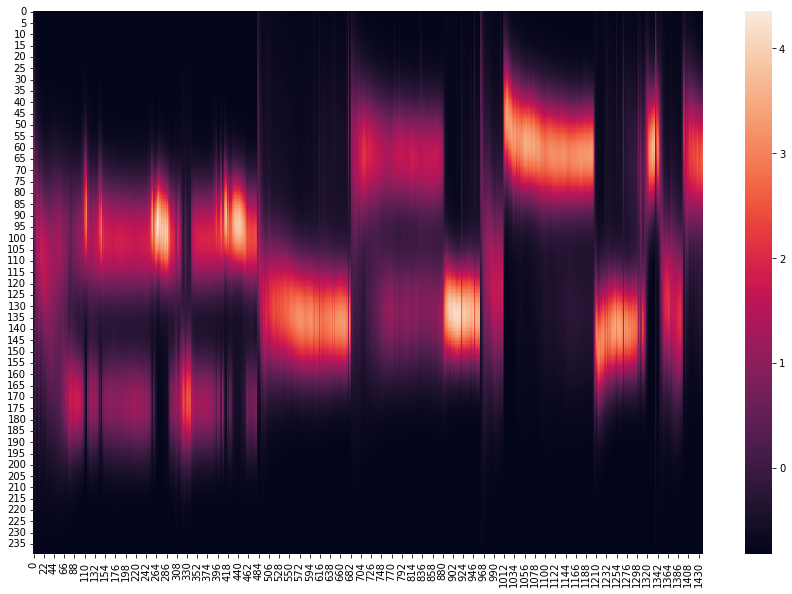

In [8]:
# quick senity check
run = 5
predprobz = stim_df[stim_df['run'] == run].filter(regex='pred_prob[_0-9.]+').to_numpy()

fig, ax = plt.subplots(1, 
                       1, 
                       sharex=True, figsize=(15,  10))

# z-score 
#  note: do we want to z-score the regressors over all voxels, otherwise we boost oudside range areas more
predprobz = (predprobz - predprobz.mean()) / predprobz.std()
#predprobz = (predprobz - predprobz.mean(axis=0)) / predprobz.std(axis=0) # dont do this

sns.heatmap( predprobz.transpose() )

In [9]:
stim_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17280 entries, 0 to 17279
Columns: 257 entries, frequencies to pred_prob_12.551
dtypes: float64(253), int64(4)
memory usage: 33.9 MB


In [10]:
stim_df

,frequencies,frequencies_oct,timing,closest_volume_rel,closest_volume_abs,volume_rel,volume_abs,run,block,segment,...,pred_prob_12.366,pred_prob_12.386,pred_prob_12.407,pred_prob_12.428,pred_prob_12.448,pred_prob_12.469,pred_prob_12.489,pred_prob_12.510,pred_prob_12.530,pred_prob_12.551
0,2896.309376,11.500000,607363.205175,5,5,6,6,1.0,1.0,1.0,...,0.020825,0.020586,0.020351,0.020120,0.019893,0.019669,0.019449,0.019233,0.019021,0.018811
1,2896.309376,11.500000,607363.455175,5,5,6,6,1.0,1.0,1.0,...,0.097496,0.095050,0.092674,0.090365,0.088123,0.085946,0.083832,0.081781,0.079791,0.077860
2,966.527296,9.916667,607363.705175,5,5,6,6,1.0,1.0,1.0,...,0.130440,0.125652,0.121054,0.116638,0.112400,0.108333,0.104430,0.100686,0.097095,0.093651
3,912.280287,9.833333,607363.955175,5,5,6,6,1.0,1.0,1.0,...,0.099633,0.096671,0.093790,0.090988,0.088265,0.085620,0.083050,0.080555,0.078134,0.075784
4,2298.802275,11.166667,607364.205175,6,6,6,6,1.0,1.0,1.0,...,0.077271,0.075055,0.072894,0.070787,0.068735,0.066737,0.064791,0.062897,0.061054,0.059261
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17275,767.133223,9.583333,613497.053499,221,2916,221,2916,12.0,36.0,10.0,...,0.000493,0.000478,0.000465,0.000452,0.000440,0.000429,0.000418,0.000408,0.000399,0.000390
17276,2169.780417,11.083333,613497.303499,221,2916,222,2917,12.0,36.0,10.0,...,0.000331,0.000320,0.000310,0.000301,0.000292,0.000284,0.000277,0.000270,0.000263,0.000257
17277,1024.000000,10.000000,613497.553499,221,2916,222,2917,12.0,36.0,10.0,...,0.001994,0.001932,0.001873,0.001816,0.001763,0.001711,0.001663,0.001616,0.001571,0.001529
17278,645.079578,9.333333,613497.803499,221,2916,222,2917,12.0,36.0,10.0,...,0.000863,0.000827,0.000792,0.000760,0.000729,0.000700,0.000673,0.000648,0.000624,0.000602


# Adaptation

In [9]:
import Adaptation.longtrace_adaptation as longtrace_adaptation
import Adaptation.longtrace_adaptation_timedomain as longtrace_adaptation_timedomain

x_decay, y_decay = longtrace_adaptation.double_exp_decay_func(0.1399, 0.85, 0.0345, 6.82, [1, 10], 1)

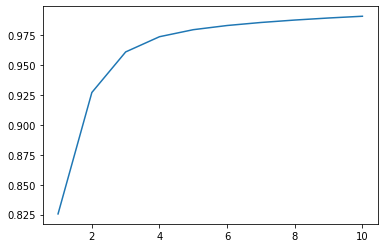

In [10]:
plt.plot(x_decay, y_decay)

In [11]:
activations, adaptations, adapted_activations, n_back_adaptations = stim_io.run_adaptation(stim_df, 
                                                                                           pref_range, 
                                                                                           sharp_range, 
                                                                                           y_decay)
stim_df = stim_io.stims_add_adaptation(stim_df, 
                                       pref_range, 
                                       sharp_range, 
                                       activations, 
                                       adaptations, 
                                       adapted_activations)

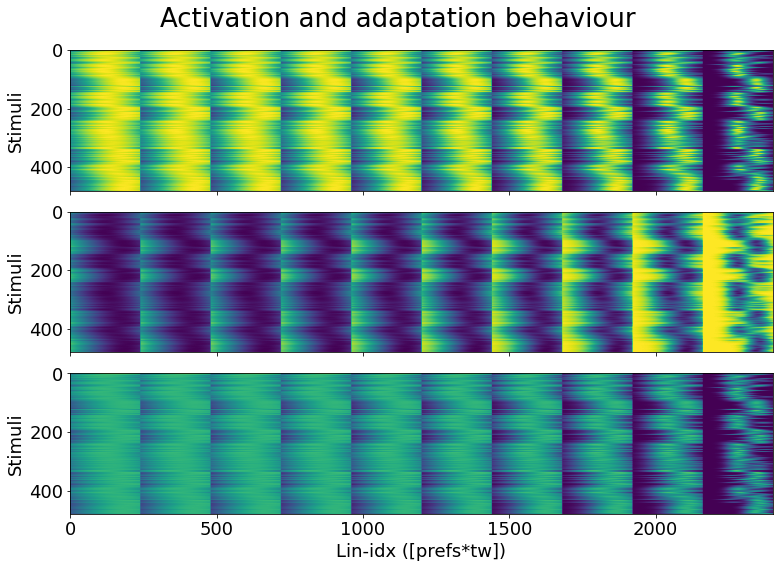

In [12]:
ax, fig = longtrace_adaptation.md_plot_activationadaptation(activations[:,:480], 
                                                            adaptations[:,:480], 
                                                            adapted_activations[:,:480])

In [13]:
stim_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17280 entries, 0 to 17279
Columns: 7457 entries, frequencies to adapt_activ_12.551_0.480
dtypes: float64(7453), int64(4)
memory usage: 983.1 MB


<AxesSubplot:>

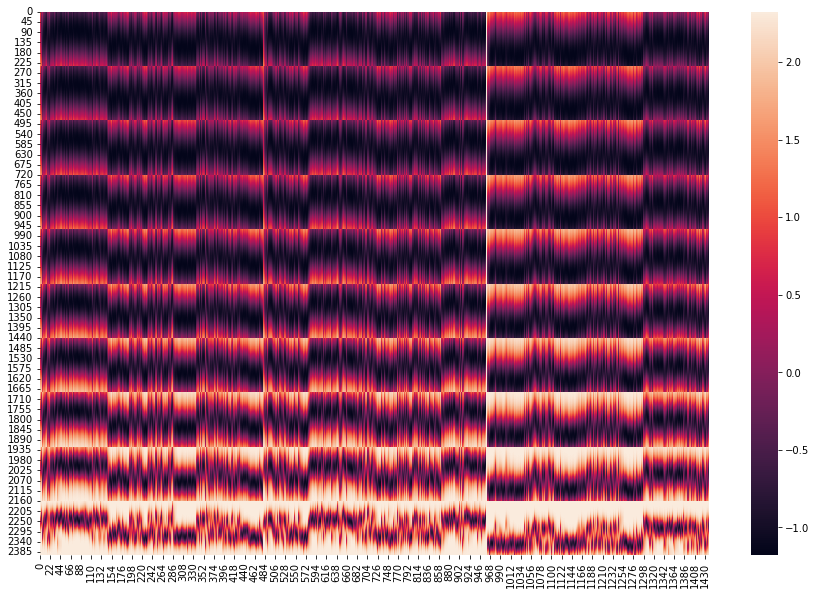

In [14]:
# quick senity check
run = 4
activs = stim_df[stim_df['run'] == run].filter(regex='adapt_[_0-9.]+').to_numpy()

# z-score 
#  note: do we want to z-score the regressors over all voxels, otherwise we boost oudside range areas more
activs = (activs - activs.mean()) / activs.std()
#predprobz = (predprobz - predprobz.mean(axis=0)) / predprobz.std(axis=0) # dont do this

fig, ax = plt.subplots(1, 
                       1, 
                       sharex=True, figsize=(15,  10))

sns.heatmap( activs.transpose() )